<a href="https://colab.research.google.com/github/KotraHaridutt/Brain-Tumor-Classification/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image,ImageSequence,ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten,Dropout,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16


In [4]:
train_dr = '/content/drive/MyDrive/MRI Images/Training'
test_dr = '/content/drive/MyDrive/MRI Images/Testing'

train_paths = []
train_labels = []
for label in os.listdir(train_dr):
  for image in os.listdir(os.path.join(train_dr, label)):
    train_paths.append(os.path.join(train_dr,label,image))
    train_labels.append(label)

train_paths,train_labels = shuffle(train_paths,train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dr):
  for image in os.listdir(os.path.join(test_dr,label)):
    test_paths.append(os.path.join(test_dr,label,image))
    test_labels.append(label)

test_paths,test_labels = shuffle(test_paths,test_labels)

In [5]:
print(len(train_paths))

5712


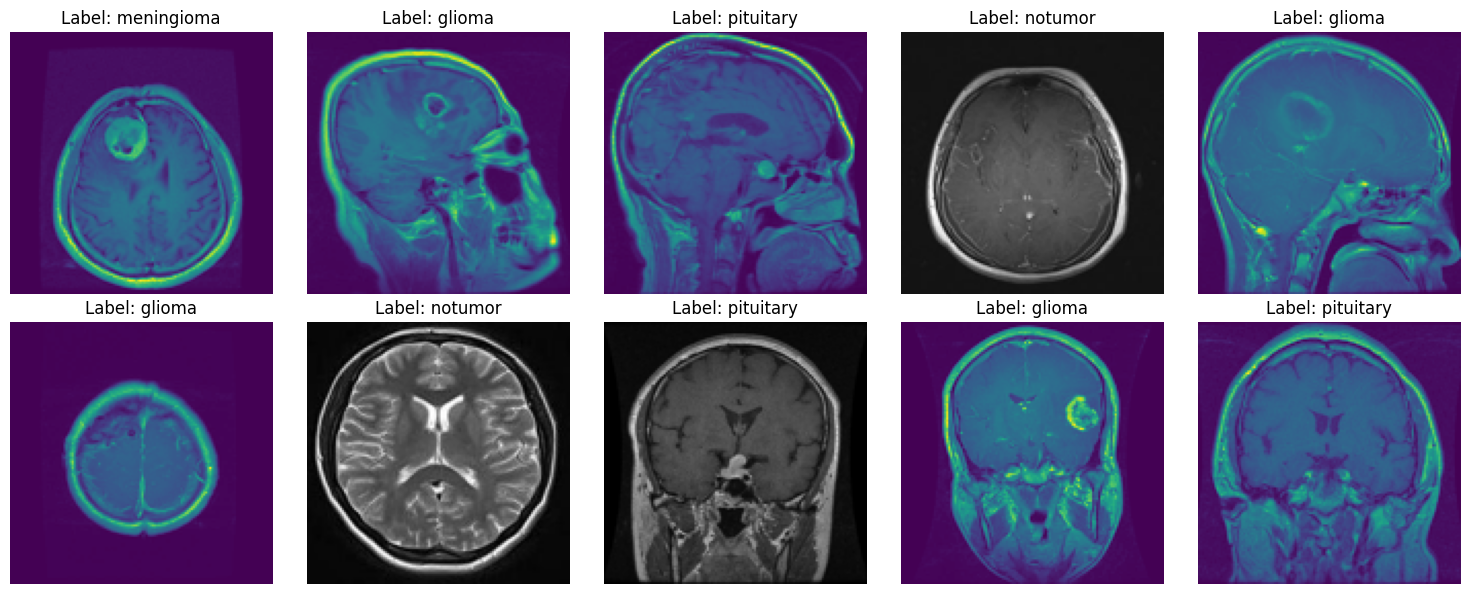

In [6]:
random_indices = random.sample(range(len(train_paths)),10)


fig,axes = plt.subplots(2,5,figsize = (15,6))
axes = axes.ravel()

for i,indx in enumerate(random_indices):
  img_path = train_paths[indx]
  img = Image.open(img_path)
  img = img.resize((128,128))

  axes[i].imshow(img)
  axes[i].axis('off')

  axes[i].set_title(f"Label: {train_labels[indx]}")

plt.tight_layout()
plt.show()

In [7]:
#Data preprocessing Helper Functions
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image = np.array(image)/255.0

  return image

def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path,target_size = (IMAGE_SIZE,IMAGE_SIZE))
    img = augment_image(img)
    images.append(img)

  return np.array(images)

def encode_label(labels):
  unique_labels = os.listdir(train_dr)
  encoded = [unique_labels.index(label) for label in labels ]
  return np.array(encoded)

def datagen(paths,labels,batch_size=12,epochs=1):
  for _ in range(epochs):
    for i in range(0,len(paths),batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images,batch_labels





In [8]:
from re import T
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dr)),activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

batch_size = 20
epochs = 5
steps = int(len(train_paths)/batch_size)

history = model.fit(
    datagen(train_paths,train_labels,batch_size=batch_size,epochs= epochs),
    epochs = epochs,
    steps_per_epoch = steps

)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3036s 11s/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7436
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.2509 - sparse_categorical_accuracy: 0.9058
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - loss: 0.1581 - sparse_categorical_accuracy: 0.9432
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.9550
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.0803 - sparse_categorical_accuracy: 0.9721


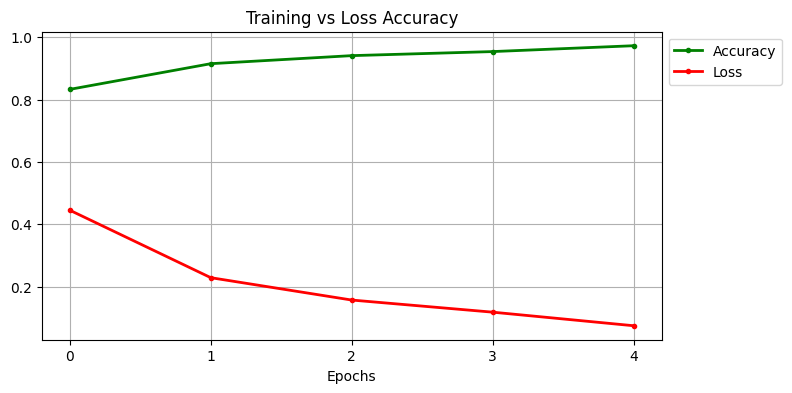

In [9]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'.g-',linewidth = 2)
plt.plot(history.history['loss'],'.r-',linewidth=2)
plt.title("Training vs Loss Accuracy")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','Loss'],loc='upper left',bbox_to_anchor=(1,1))

plt.show()

In [10]:
from sklearn.metrics import classification_report,confusion_matrix

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels) #y_true

test_predictions = model.predict(test_images)
print("Classification Report : ")
print(classification_report(test_labels_encoded,np.argmax(test_predictions,axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       300
           1       1.00      1.00      1.00       405
           2       0.90      0.95      0.92       306
           3       0.95      0.90      0.92       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



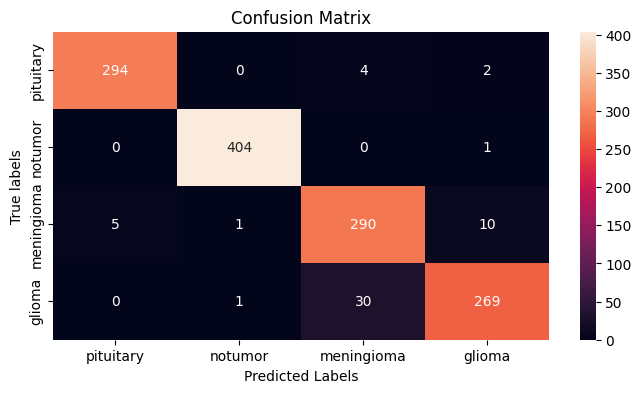

In [11]:
import seaborn as sns
cnf_matrix = confusion_matrix(test_labels_encoded,np.argmax(test_predictions,axis=1))

plt.figure(figsize=(8,4))

sns.heatmap(cnf_matrix,annot=True,fmt='g',xticklabels=os.listdir(train_dr),yticklabels=os.listdir(train_dr))
plt.xlabel("Predicted Labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


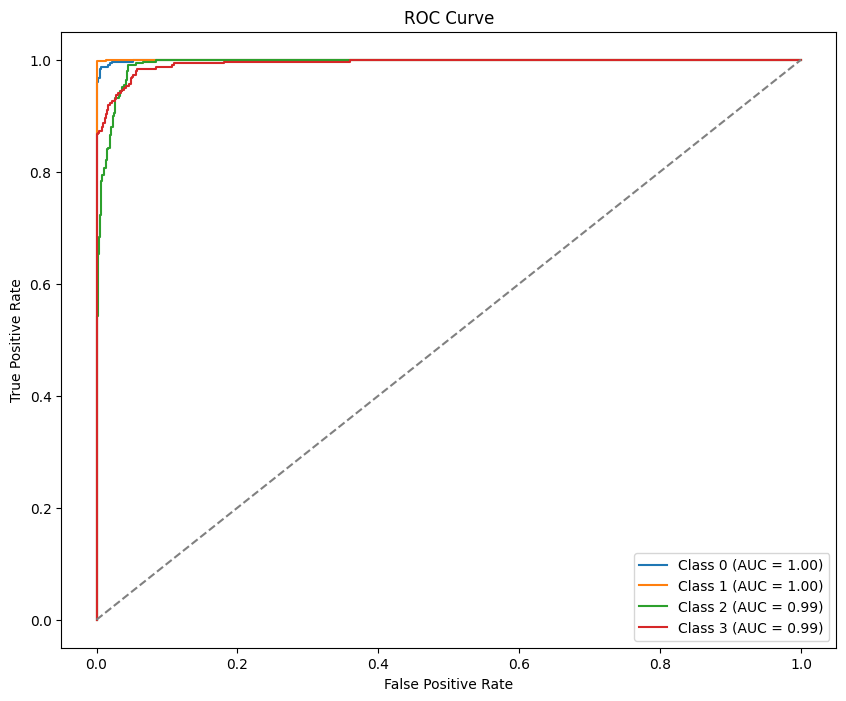

In [12]:
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize

# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dr))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dr))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dr))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('/content/my_model.h5')

In [ ]:
!cp /content/my_model.h5 /content/drive/MyDrive/

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/my_model.h5')

In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


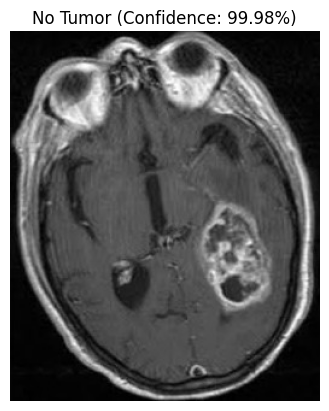

In [16]:
# Example usage
image_path = '/content/drive/MyDrive/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)